# Autoregressive Models

On this Notebook, some Autoregressive Models are tried in the job to solve the competition problem. The idea here is to find the most suitable model to use on an Ensemble with other constructed model.

## Libraries

In [57]:
import numpy as np 
import pandas as pd 
from cnr_methods import get_simplified_data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

## Data Extraction

In [58]:
full_data, full_label = get_simplified_data()

To simplify the analysis, let's work only with Training Data of Wind Farm 1.

In [59]:
X = full_data[full_data['Set']=='Train']
X = X[X['WF']=='WF1']
y = full_label[full_label.index.isin(X['ID'])]

## Facebook Prophet

The First method that will be tried is the Facebooks's Prophet. First thing to do is convert the data to the Standard Format required by Prophet.

In [60]:
y = y.reset_index()
y = y.merge(X.reset_index()[['Time','ID']],on='ID',how='left')
y = y[['Time','Production']]
y.columns = ['ds','y']

In [61]:
y.head()

,ds,y
0,2018-05-01 01:00:00,0.02
1,2018-05-01 02:00:00,0.07
2,2018-05-01 03:00:00,0.22
3,2018-05-01 04:00:00,0.39
4,2018-05-01 05:00:00,0.41


Let's divide the Data on Train and Hold Set. As the data has nearly 8 months of data, we'll separate the last month as the Holdout Set.

In [62]:
split = round(7*len(y)/8)

y_train = y[:split]
y_hold = y[split:]

Now, let's apply the Model.

In [63]:
m = Prophet(growth='logistic',n_changepoints=25,changepoint_prior_scale = 10000,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)
#m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=100)

In [64]:
y_train['floor'] = 0
y_train['cap'] = 10

In [65]:
m.fit(y_train)

In [66]:
future = m.make_future_dataframe(periods=780,freq='H',include_history=True)

In [67]:
future['floor'] = 0
future['cap'] = 10

In [68]:
forecast = m.predict(future)

In [69]:
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

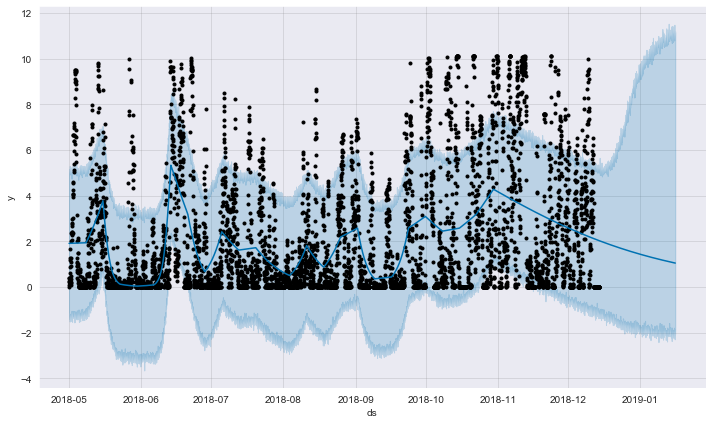

In [70]:
fig1 = m.plot(forecast)

In [71]:
preds = forecast[-780:]

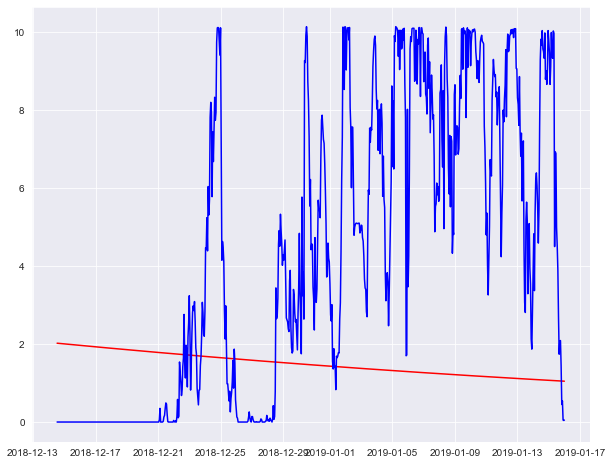

In [72]:
plt.figure(figsize=(10,8))
plt.plot(preds['ds'],preds['yhat'],'r',label='Predictions')
plt.plot(preds['ds'],y_hold['y'],'b',label='True Values')

## ARIMA

Here, we implement the ARIMA Model.

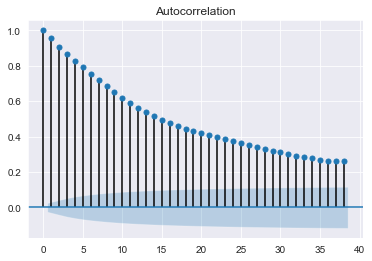

In [73]:
fig1 = plot_acf(y['y'])

In [82]:
model = ARIMA(y_train['y'], order=(15,0,10))

In [83]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5459
Model:                   ARMA(15, 10)   Log Likelihood               -6985.753
Method:                       css-mle   S.D. of innovations              0.870
Date:                Tue, 09 Jun 2020   AIC                          14025.506
Time:                        18:35:27   BIC                          14203.842
Sample:                             0   HQIC                         14087.733
                                          

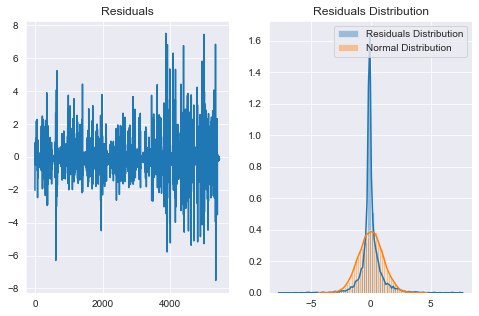

In [84]:
residuals = pd.DataFrame(model_fit.resid)
fig = plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.plot(residuals.index,residuals[0])
plt.title('Residuals')

plt.subplot(1,2,2)
sns.distplot(residuals,label='Residuals Distribution')
sns.distplot(np.random.normal(0,1,10000),label='Normal Distribution')
plt.title('Residuals Distribution')
plt.legend()

Text(0.5, 1.0, 'QQ-Plot')

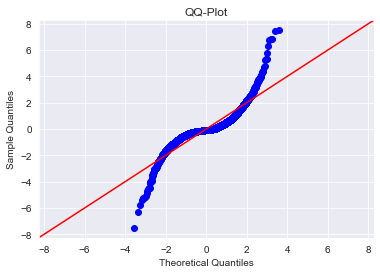

In [85]:
qqplot(residuals[0],line='45')
plt.title('QQ-Plot')

Text(0.5, 1.0, 'Autocorrelation')

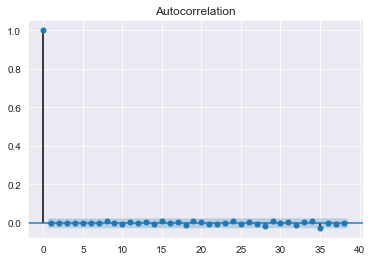

In [86]:
plot_acf(residuals[0])
plt.title('Autocorrelation')

In [87]:
fc, se, conf = model_fit.forecast(780, alpha=0.05)  # 95% conf

In [88]:
fc_series = pd.Series(fc, index=y_hold.index)
lower_series = pd.Series(conf[:, 0], index=y_hold.index)
upper_series = pd.Series(conf[:, 1], index=y_hold.index)

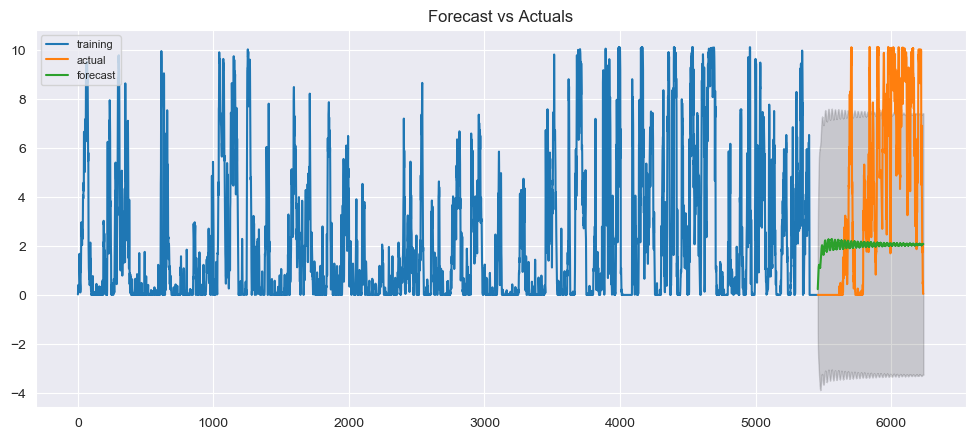

In [89]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train['y'], label='training')
plt.plot(y_hold['y'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()